# Оптимизация процесса обработки стали.

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Нам предстоит построить модель, которая предскажет температуру стали.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

## План работы:

1. Обзор и загрузка данных:
  - Обзор и загрузка данных, приведение данных дат к типу "дата".
  - общий анализ данных датасета.
2. Исследовательский анализ данных:
  - Анализ распределения в данных.
  - Анализ данных на выбросы.
  - Анализ пропущенных значений и аномалий.
3. Предобработка данных:
 - Заполнение пропусков в данных.
 - Обработка аномалий в данных(удаление ключей с заниженной температурой и аномальными значениями признаков).
 - Создание новых признаков(суммарная мощность по ключу, работа, длительность нагрева, отношение активной мощности к реативной).
 - Проверка корреляции и мультиколлинеарности признаков и целевого признака.
 - Аггрегация данных по ключу и трансформация исходных датафреймов.
 - Создание объединенного датафрейма.
 - Удаление лишних признаков.
4. Создание набора признаков и целевого признака.
5. Разделение общего набора на тренировочную и тестовую выборки.
6. Выбор моделей для обучения:
  - Создание наборов с гиперпараметрами для обучения моделей.
  - Обучение и валидация моделей.
  - Датафрейм с гиперпараметрами, дающими лучший результат метрики.
7. Проверка лучшей модели на тестовой выборке.
7. Выводы и рекомендации по исследованию.

## Вопросы:

## Шаг 1. Обзор и загрузка данных.

In [1]:
# импорт основных библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# импорт библиотек моделей 
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# импорт библиотек с метриками 
from sklearn.metrics import  mean_absolute_error 
from sklearn.model_selection import cross_val_score

# импорт методов стандартизации и pipline 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#импорт GridSearchCV 
from sklearn.model_selection import GridSearchCV

import re

import datetime, time
from time import time

# импорт библиотеки для предупреждений
import warnings
warnings.filterwarnings('ignore')


Bad key text.latex.preview in file C:\Users\regki\anaconda3\envs\praktikum_env_win_new\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\regki\anaconda3\envs\praktikum_env_win_new\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\regki\anaconda3\envs\praktikum_env_win_new\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 418 ('savefig.jpeg_qua

In [2]:
# чтение датасета с применением конструкции try - except
try:
    df_arc = pd.read_csv('/Users/regki/Downloads/data_arc.csv', parse_dates=['Начало нагрева дугой', 'Конец нагрева дугой'])
    df_bulk = pd.read_csv('/Users/regki/Downloads/data_bulk.csv')
    df_bulk_time = pd.read_csv('/Users/regki/Downloads/data_bulk_time.csv', parse_dates=['Bulk 1','Bulk 2', 'Bulk 3', 'Bulk 4',
            'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15'])
    df_gas = pd.read_csv('/Users/regki/Downloads/data_gas.csv')
    df_temp = pd.read_csv('/Users/regki/Downloads/data_temp.csv', parse_dates=['Время замера'])
    df_wire = pd.read_csv('/Users/regki/Downloads/data_wire.csv')
    df_wire_time = pd.read_csv('/Users/regki/Downloads/data_wire_time.csv', parse_dates=['Wire 1', 'Wire 2', 'Wire 3', 'Wire 4',
                                                                'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9'])
except:
    df_arc = pd.read_csv('/datasets/final_steel/data_arc.csv', parse_dates=['Начало нагрева дугой', 'Конец нагрева дугой'])
    df_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
    df_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv', parse_dates=['Bulk 1','Bulk 2', 'Bulk 3', 'Bulk 4',
            'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15'])
    df_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
    df_temp = pd.read_csv('/datasets/final_steel/data_temp.csv', parse_dates=['Время замера'])  
    df_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
    df_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv', parse_dates=['Wire 1', 'Wire 2', 'Wire 3', 'Wire 4',
                                                                'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9'])

In [3]:
# создание списков с датасетами и их наименованиями
list_df = [df_arc, df_bulk, df_bulk_time, df_gas, df_temp, df_wire, df_wire_time]
list_name_df = ['ДАННЫЕ ОБ ЭЛЕКТРОДАХ', 'ДАННЫЕ О ПОДАЧЕ СЫПУЧИХ МАТЕРИАЛОВ(ОБЪЁМ)', 
                  'ДАННЫЕ О ПОДАЧЕ СЫПУЧИХ МАТЕРИАЛОВ(ВРЕМЯ)', 'ДАННЫЕ О ПРОДУВКЕ СПЛАВА ГАЗОМ',
                  'РЕЗУЛЬТАТЫ ИЗМЕРЕНИЯ ТЕМПЕРАТУРЫ', 'ДАННЫЕ О ПРОВОЛОЧНЫХ МАТЕРИАЛАХ(ОБЪЁМ)',
                  'ДАННЫЕ О ПРОВОЛОЧНЫХ МАТЕРИАЛАХ(ВРЕМЯ)']

In [4]:
# обзор данных датасетов в цикле
for i in range(len(list_df)):
    print(list_name_df[i])
    print()
    display(list_df[i].info())
    display(list_df[i])
    print('\n\n')

ДАННЫЕ ОБ ЭЛЕКТРОДАХ

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


None

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768





ДАННЫЕ О ПОДАЧЕ СЫПУЧИХ МАТЕРИАЛОВ(ОБЪЁМ)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0





ДАННЫЕ О ПОДАЧЕ СЫПУЧИХ МАТЕРИАЛОВ(ВРЕМЯ)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaT,NaT,NaT,2019-05-03 11:46:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaT,NaT,NaT,2019-05-03 12:31:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:09:40,NaT,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaT,NaT,NaT,2019-05-03 12:48:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:41:24,NaT,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaT,NaT,NaT,2019-05-03 13:18:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:12:56,NaT,2019-05-03 13:12:56,2019-05-03 13:12:56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaT,NaT,2019-08-31 22:51:28,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-08-31 22:46:52,NaT,2019-08-31 22:46:52,2019-08-31 22:46:52
3125,3238,NaT,NaT,2019-08-31 23:39:11,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-08-31 23:33:09,NaT,2019-08-31 23:33:09,2019-08-31 23:33:09
3126,3239,NaT,NaT,NaT,NaT,NaT,2019-09-01 01:51:58,NaT,NaT,NaT,NaT,NaT,2019-09-01 01:39:41,NaT,2019-09-01 01:33:25,2019-09-01 01:33:25
3127,3240,NaT,NaT,NaT,NaT,NaT,2019-09-01 03:12:40,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-09-01 02:41:27,2019-09-01 02:41:27





ДАННЫЕ О ПРОДУВКЕ СПЛАВА ГАЗОМ

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103





РЕЗУЛЬТАТЫ ИЗМЕРЕНИЯ ТЕМПЕРАТУРЫ

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           15907 non-null  int64         
 1   Время замера  15907 non-null  datetime64[ns]
 2   Температура   13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


None

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN





ДАННЫЕ О ПРОВОЛОЧНЫХ МАТЕРИАЛАХ(ОБЪЁМ)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN





ДАННЫЕ О ПРОВОЛОЧНЫХ МАТЕРИАЛАХ(ВРЕМЯ)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:46:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:13:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:48:05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-08-31 22:50:20,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3077,3238,2019-08-31 23:38:24,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3078,3239,2019-09-01 01:50:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3079,3240,2019-09-01 03:12:02,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


 - При первичном обзоре данных выяснилось, что пропуски в данных отсутствуют только в 2-х датасетах: в данных об применении электродов и продувке сплава газом. 
 - Данные по целевому признаку имеют существенное количество пропусков, далее более детально разберем это.
 - В данных о добавлении сыпучих материалов и применения проволоки имеется большое число пропусков.
 - Причем данные о пропусках в парах таблиц по объему и времени совпадают, то есть объем данных в них одинаков, поэтому таблицы с датами скорее всего полностью отражают время добавления к сплаву того или иного материала. 

## Шаг 2. Исследовательский анализ данных.

Создадим функции для получения статистики по данным и визуализации распределения:
 - Первая функция принимает аргументом датафрейм, внутри происходит рассчет основных статитстических показателей.
 - Вторая функция:
   - Принимает аргументами датафрейм, список с признаками, заголовок и надпись по оси Х.
   - Строит гистограмму распределения по признаку
   - Строит красным цветом медиану, а также желтыми линиями 1 и 3 квартили, прерывистыми полуторный интерквартильный размах.

In [5]:
# создание функции для получения статистики по датафрейму
def describe_tab(data):
    display(data.describe(datetime_is_numeric=True).loc[['count', 'mean', 'min', 'max', '50%', '25%', '75%']])

In [6]:
# создание функции для построения гистограмм, где красная линия - медиана, оранжевые 1 и 3 квартили, а прерывистые -
# - полуторный интерквартильный размах
def hist_feature(data, list_feat, header, x_labe):
    for i in range(1, len(list_feat)):
        iqr = (data[list_feat[i]].quantile(0.75) - data[list_feat[i]].quantile(0.25))
        data.hist(list_feat[i], grid='True', bins=50, alpha=0.4, rwidth=0.6, legend=True, figsize=(16,6))
        plt.title(header + ' ' + list_feat[i], fontsize=14)
        plt.xlabel(x_labe, fontsize=14)
        plt.ylabel('Частота', fontsize=14)
        plt.axvline( x=data[list_feat[i]].median() , ymin=0 , c='red' , lw=2 )
        plt.axvline( x=data[list_feat[i]].quantile(0.25) , ymin=0 , c='orange' , lw=1 )
        plt.axvline( x=data[list_feat[i]].quantile(0.75) , ymin=0 , c='orange' , lw=1 )
        plt.axvline(x=(data[list_feat[i]].quantile(0.25) - 1.5*iqr) , c='orange' , lw=3 , ls=':')
        plt.axvline(x=(data[list_feat[i]].quantile(0.75) + 1.5*iqr) , c='orange' , lw=3 , ls=':')

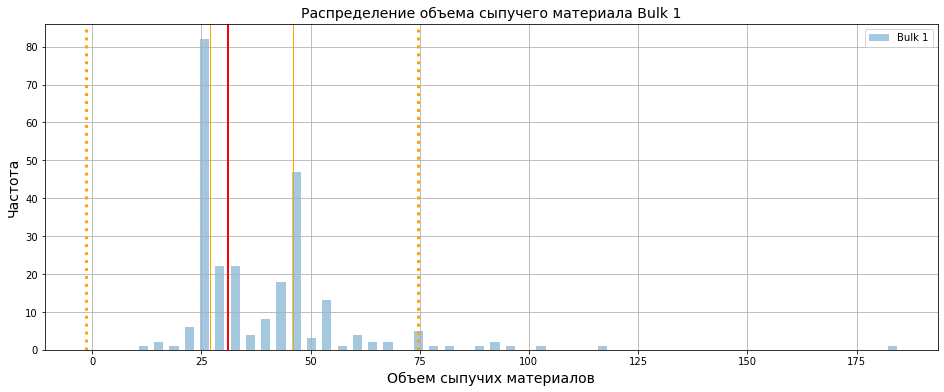

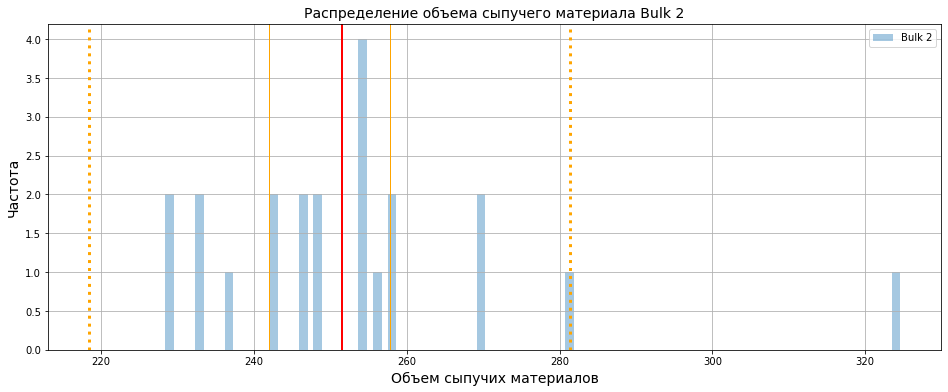

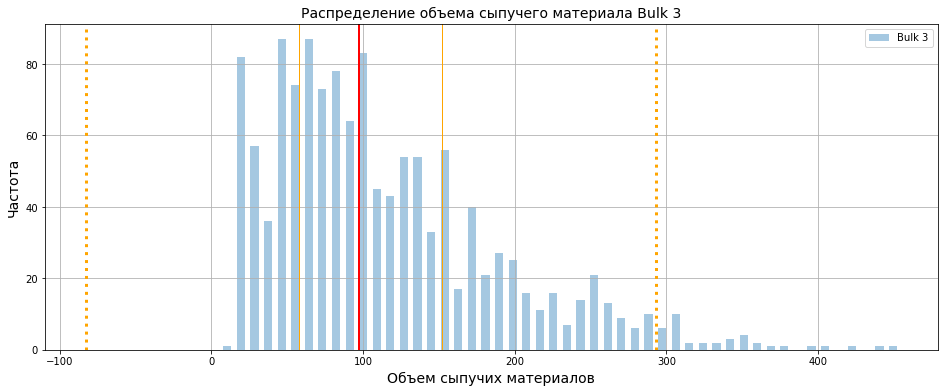

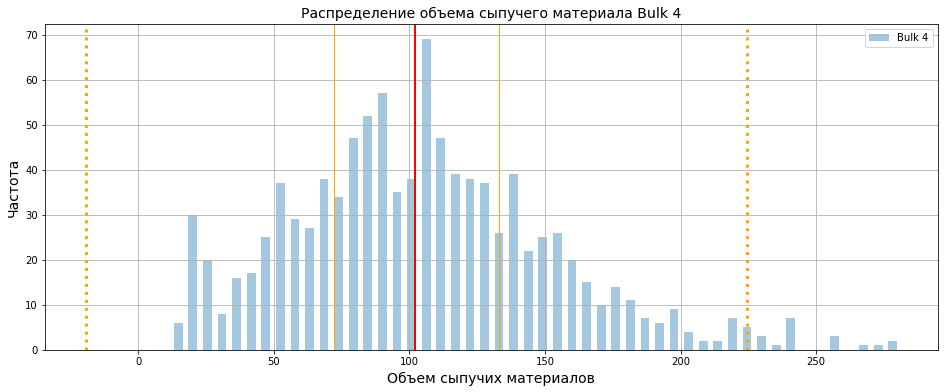

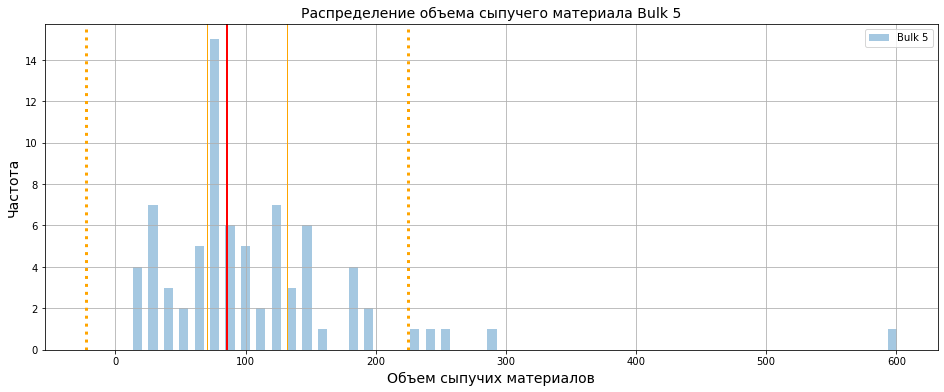

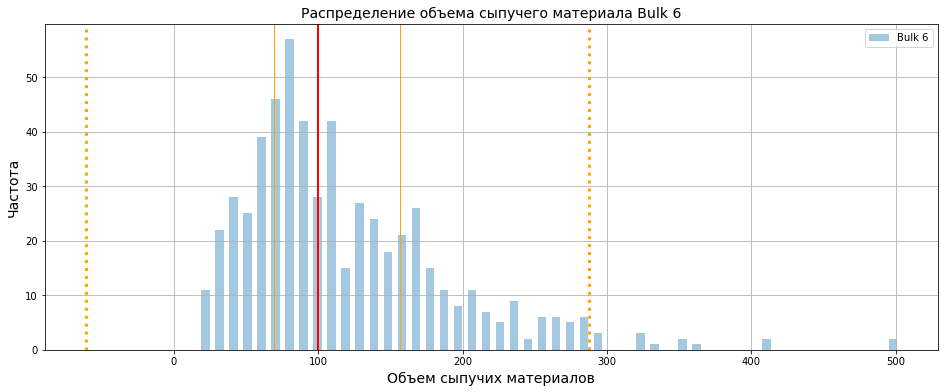

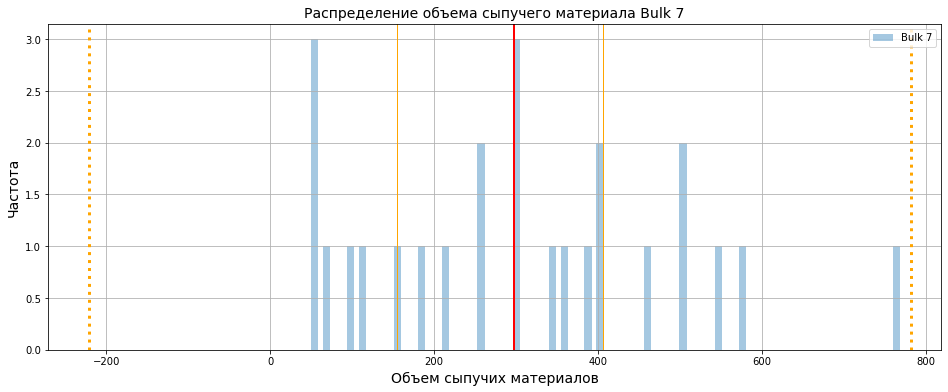

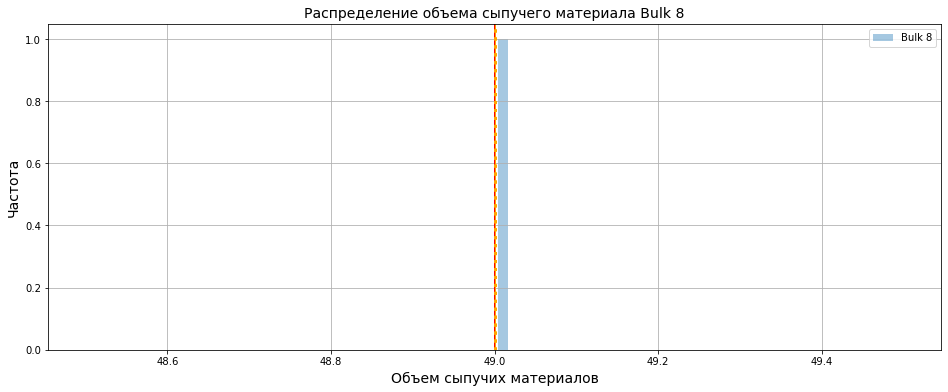

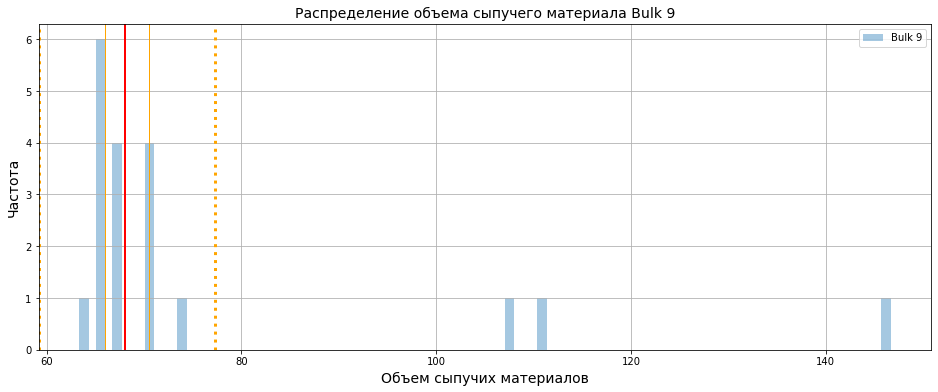

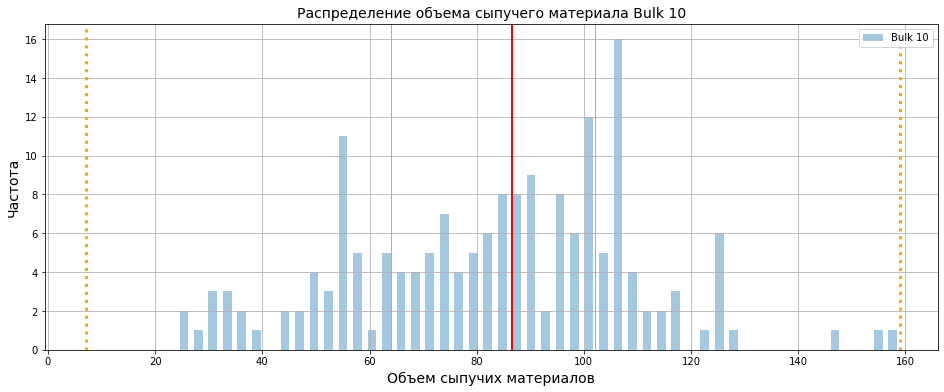

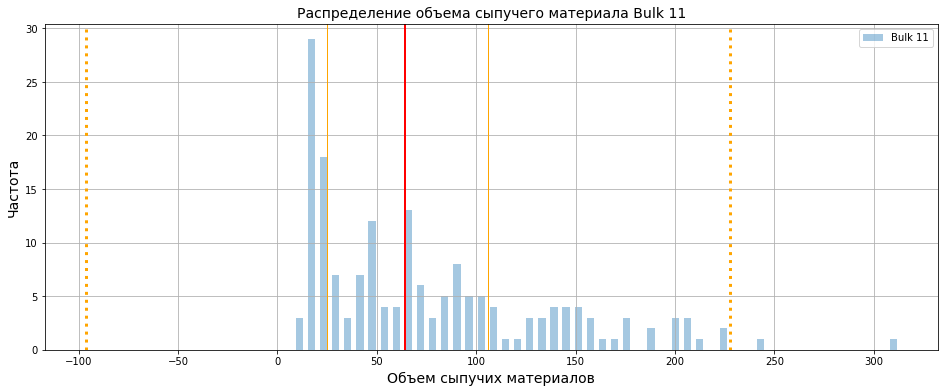

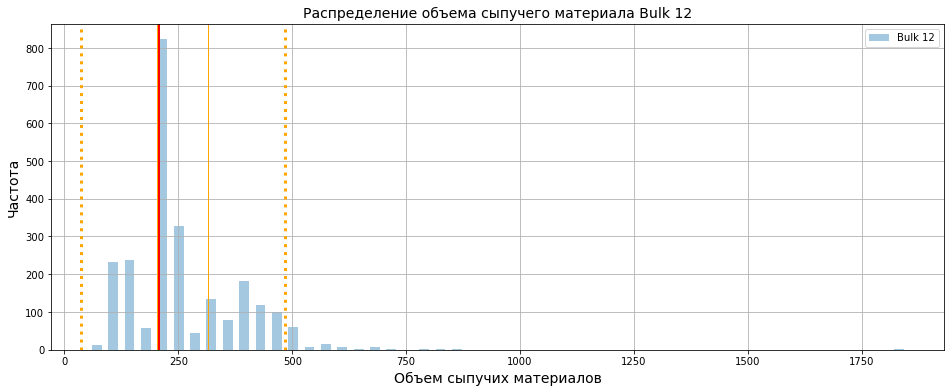

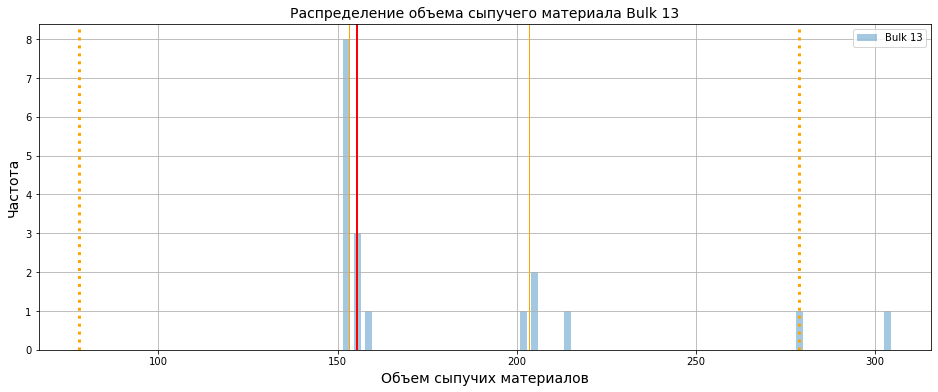

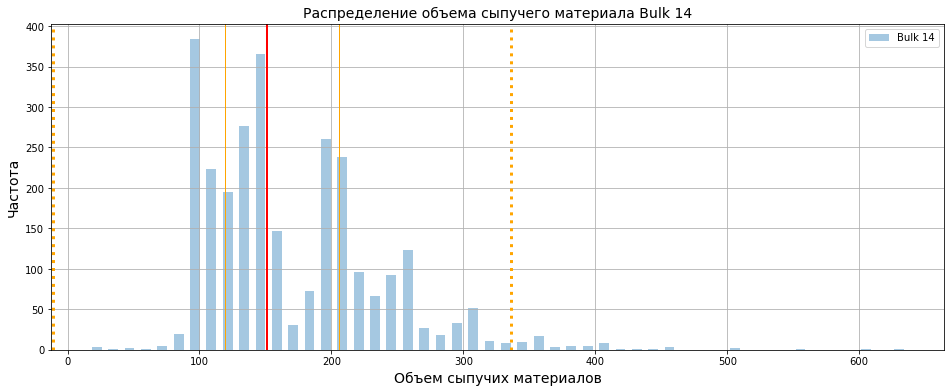

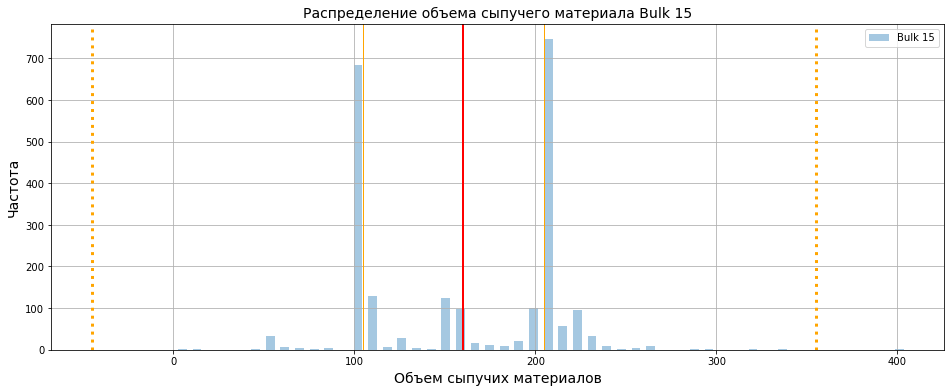

In [7]:
# вызов функции для построения гистограмм по признакам датафрейма "bulk" 
hist_feature(df_bulk, df_bulk.columns.tolist(), 'Распределение объема сыпучего материала', 'Объем сыпучих материалов')

In [8]:
# описание данных датафрейма "bulk"
describe_tab(df_bulk)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.0,1.0,19.000000,176.000000,177.000000,2450.00000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.6,49.0,76.315789,83.284091,76.819209,260.47102,181.111111,170.284747,160.513345
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.0,49.0,63.000000,24.000000,8.000000,53.00000,151.000000,16.000000,1.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.0,49.0,147.000000,159.000000,313.000000,1849.00000,305.000000,636.000000,405.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.0,49.0,68.000000,86.500000,64.000000,208.00000,155.500000,151.000000,160.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.0,49.0,66.000000,64.000000,25.000000,204.00000,153.250000,119.000000,105.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.0,49.0,70.500000,102.000000,106.000000,316.00000,203.500000,205.750000,205.000000


- В основном распределение данных в признаках выглядит довольно хаотично и далеко от нормального. 
- Лишь Bulk 3, Bulk 4, Bulk 5 и Bulk 6 по виду близки к нормальному распределению.
- Чаще всего добавлялись материалы под номерами 3, 4, 12, 14, 15.
- Реже применялись сыпучие материалы с номерами 2, 7, 8, 9 и 13. Причем 8 всего 1 раз.
- В основном медианное значение немного, но меньше среднего, что говорит о смещении данных вправо от начала оси Х.
- В данных с номерами 1, 9 и 5 есть значения, которые существенно выходят за пределы полуторного интерквартильного размаха, которые могут ощутимо повлиять на результат обучения модели.

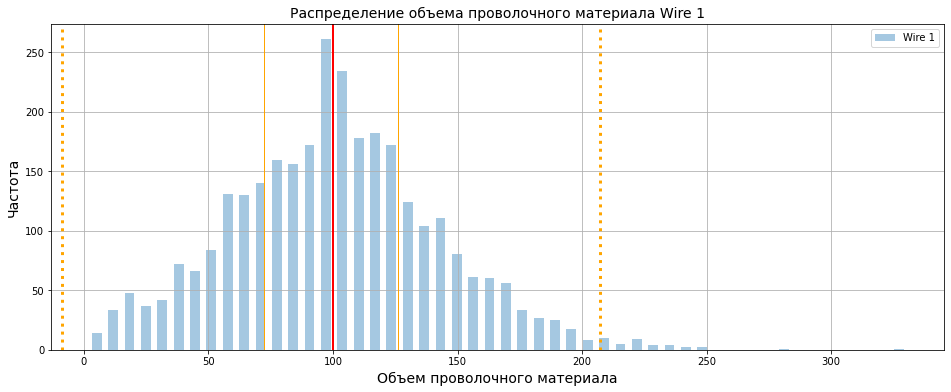

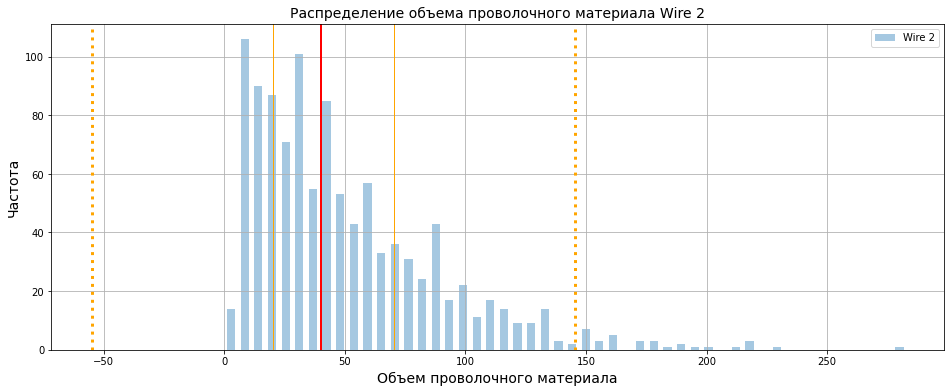

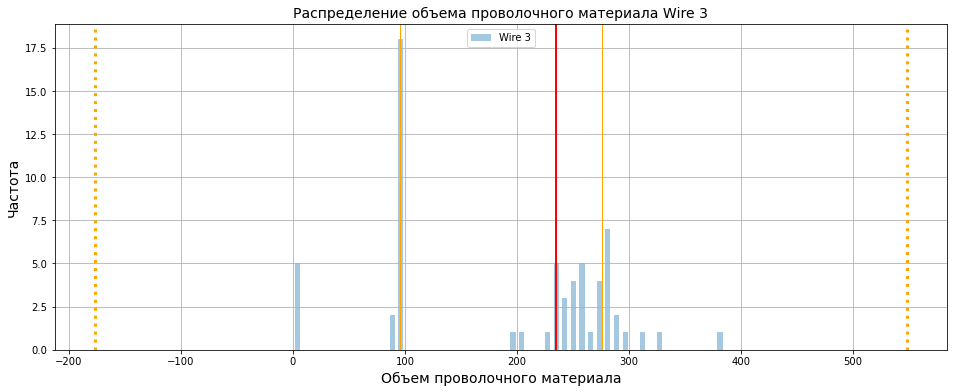

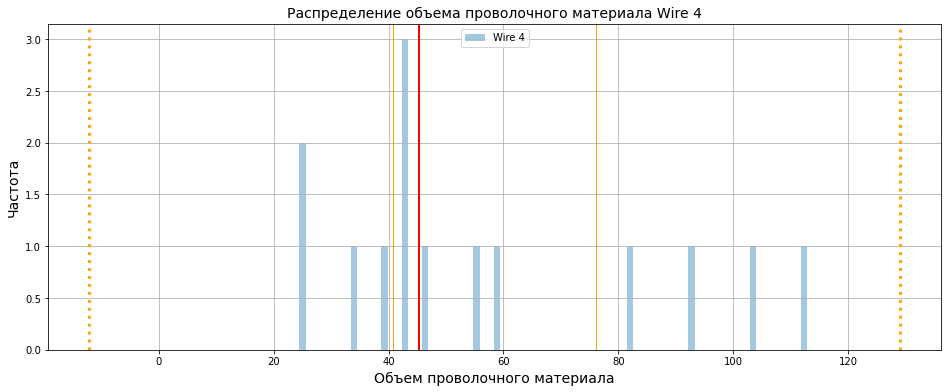

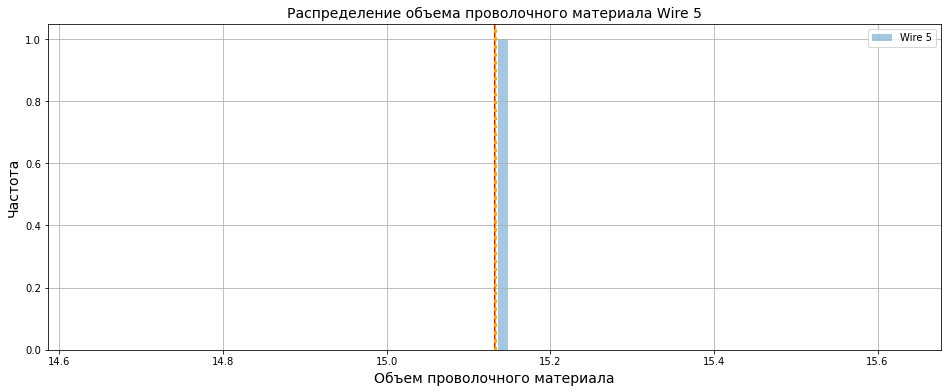

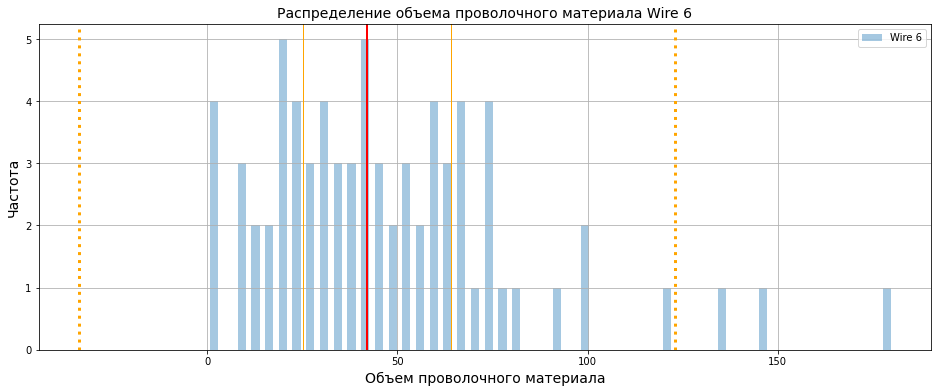

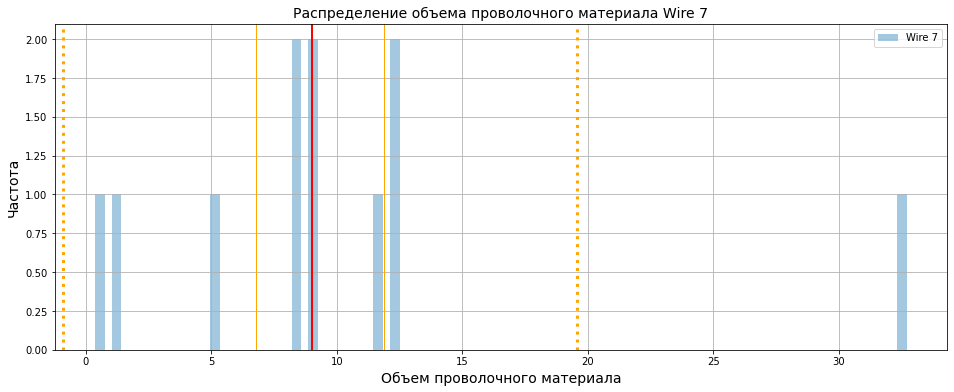

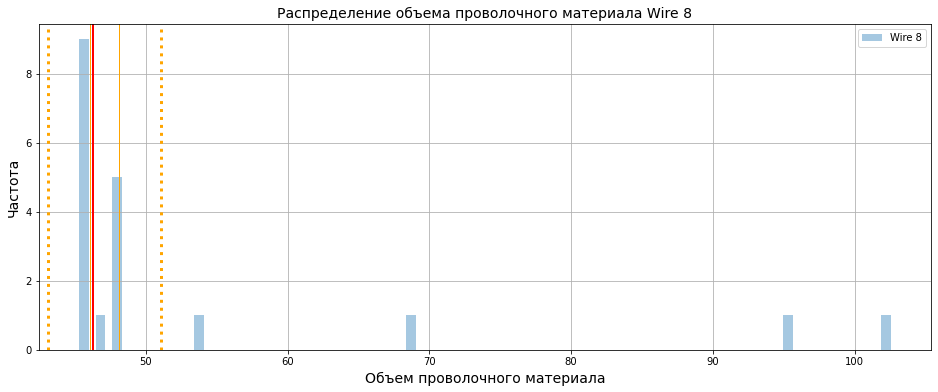

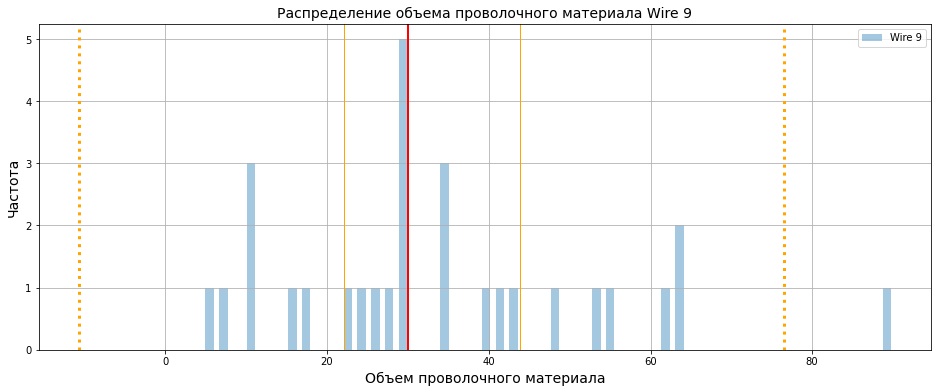

In [9]:
# вызов функции для построения гистограмм по признакам датафрейма "wire" 
hist_feature(df_wire, df_wire.columns.tolist(), 'Распределение объема проволочного материала',
              'Объем проволочного материала')

In [10]:
# описание данных датафрейма "wire"
describe_tab(df_wire)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442842,15.132,48.016974,10.039007,53.625193,34.155752
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003


- Вид распределения проволочного материала близко к нормальному можно наблюдать по добавлению позиции номер 1.
- Материалы со 2 по 9 имеют смещение данных в правую сторону от начало иси Х.
- Основными проволочными материалами, которые добавляли в работу были позиции 1 и 2. 
- Остальные материалы добавляли до нескольких десятков раз, номер 5 всего лишь 1 раз.
- В распределении 1, 2 и 7 имеются довольно большие значения, которые выходят за полутораквартильный размах, в материале номер 8 данные выходят за пределы "усов" боксплота более чем в 2 раза.

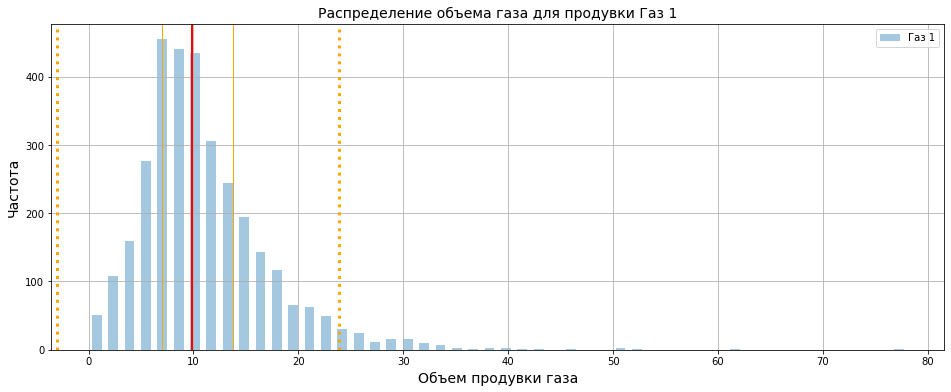

In [11]:
# вызов функции для построения гистограмм по признакам датафрейма "gas" 
hist_feature(df_gas, df_gas.columns.tolist(), 'Распределение объема газа для продувки',
              'Объем продувки газа')

In [12]:
# описание данных датафрейма "gas"
describe_tab(df_gas)

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
min,1.000000,0.008399
max,3241.000000,77.995040
50%,1622.000000,9.836267
25%,812.500000,7.043089
75%,2431.500000,13.769915


- В данных по газу есть смещение распределения в право.
- Количество ключей в данном датасете самое большое.
- Вцелом данные имеют вид распределения близкий к нормальному и медианное значение почти равно среднему.

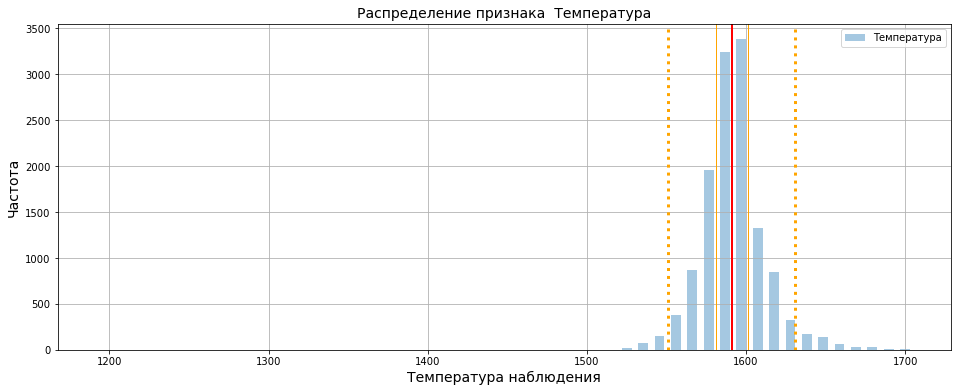

In [13]:
# вызов функции для построения гистограмм по признакам датафрейма с температурой замера 
df_temp_hist = df_temp.drop('Время замера', axis=1)
hist_feature(df_temp_hist, df_temp_hist.columns.tolist(), 'Распределение признака ',
              'Температура наблюдения')

In [14]:
# описание данных датафрейма "gas" с температурой замера 
describe_tab(df_temp_hist)

,key,Температура
count,15907.00000,13006.00000
mean,1607.88087,1591.84092
min,1.00000,1191.00000
max,3241.00000,1705.00000
50%,1618.00000,1591.00000
25%,790.00000,1581.00000
75%,2427.00000,1601.00000


- Распределение температуры в форме "купола" и почти не имеет смещения от медианного значения.
- Наблюдаются температуры сильно ниже температуры плавления стали, по договоренности с заказчиком ключи в которых температура ниже 1500 удалим.
- Наибольшее число наблюдений в районе 1600 градусов.
- Количество измерений температуры в разных партиях может сильно отличаться.
- В некоторых партиях пропущены последние измерения, посмотрим далее датафрейм с пропущенными значениями.

<font color='steelblue'><b>Комментарий тимлида</b></font><br>
<font color='green'>✔️ Согласна.</font><br>

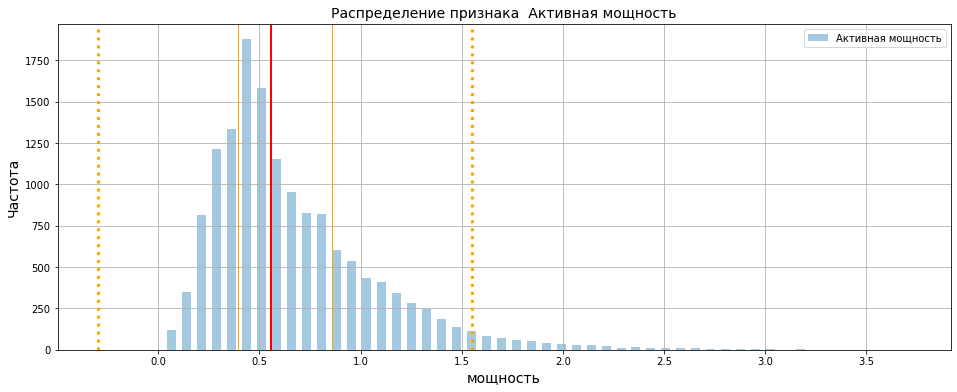

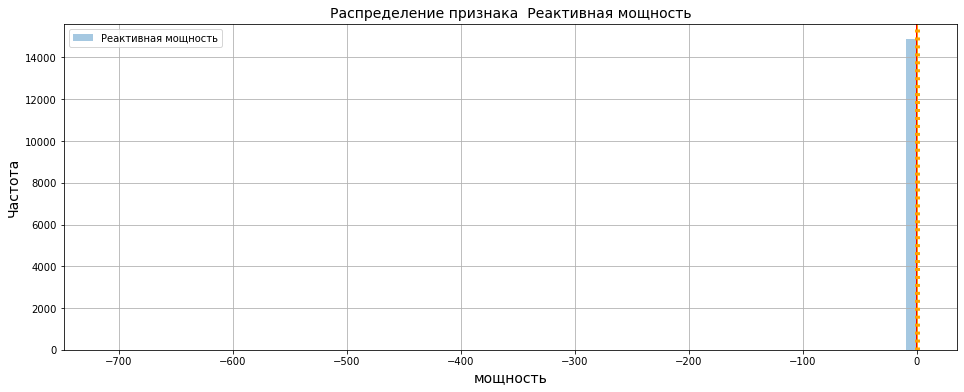

In [15]:
# вызов функции для построения гистограмм по признакам датафрейма с электродами 
df_arc_hist = df_arc.drop(['Начало нагрева дугой', 'Конец нагрева дугой'], axis=1)
hist_feature(df_arc_hist, df_arc_hist.columns.tolist(), 'Распределение признака ',
              'мощность')

In [16]:
# описание данных датафрейма "gas" с электродами 
describe_tab(df_arc_hist)

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
min,1.000000,0.030002,-715.504924
max,3241.000000,3.731596,2.676388
50%,1617.000000,0.555517,0.415962
25%,806.000000,0.395297,0.290991
75%,2429.000000,0.857034,0.637371


- В значениях активной мощности имеется существенное смещение значений вправо.
- Максимальное и минимальное значения активной мощности в разы отличаются от среднего и медианы.
- В значении реактивной мощности присутствуют отрицательные значения.
- Распределение реактивной мощности возможно рассмотреть, только в процессе предобработки, после того как удалим ключи с отрицательными значения. Выясним далее количество отрицательных значений реактивной мощности.

<AxesSubplot:xlabel='Реактивная мощность'>

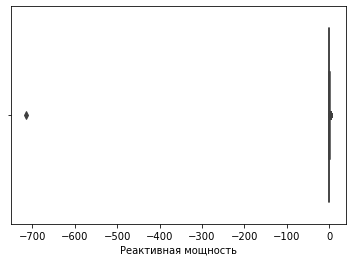

In [17]:
# построение боксплота для разброса данных по реактивной мощности
sns.boxplot(x=df_arc['Реактивная мощность'])

In [18]:
# нахождение количества отрицательных значений реактивной мощности
print('Количество отрицательных значений в признаке Реактивная мощность', 
      df_arc[df_arc['Реактивная мощность'] < 0]['Реактивная мощность'].count())

Количество отрицательных значений в признаке Реактивная мощность 1


- Количество отрицательных значений в признаке Реактивной мощности равно 1. В предобработке удалим один ключ с этим значением.

Далее рассмотрим на адекватность значения таблиц со временем добавления сыпучих добавок и проволоки.

In [19]:
# описание данных датафрейма со временем добавления сыпучих материалов
describe_tab(df_bulk_time)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252,22,1298,1014,77,576,25,1,19,176,177,2450,18,2806,2248
mean,1624.383509,2019-06-27 08:32:26.031746048,2019-07-09 02:04:44.545454336,2019-07-05 14:02:19.653312768,2019-06-30 17:27:38.687376896,2019-07-10 12:23:28.623376640,2019-07-03 15:57:30.003472384,2019-07-23 21:38:41.040000,2019-07-05 17:46:11,2019-06-21 00:53:43.157894912,2019-07-04 02:03:09.647727616,2019-07-11 23:35:46.310734336,2019-07-03 02:04:28.317142784,2019-06-29 02:00:06.722222336,2019-07-03 10:03:08.939059200,2019-07-03 16:07:21.480871936
min,1.000000,2019-05-03 17:50:19,2019-05-07 08:36:19,2019-05-03 20:13:36,2019-05-03 11:21:30,2019-05-07 08:36:19,2019-05-03 18:52:57,2019-05-07 11:37:42,2019-07-05 17:46:11,2019-05-14 00:04:56,2019-05-06 01:36:24,2019-05-05 16:45:05,2019-05-03 11:03:52,2019-05-05 00:39:35,2019-05-03 11:03:52,2019-05-03 11:03:52
max,3241.000000,2019-08-30 23:01:32,2019-08-08 17:34:38,2019-08-31 23:39:11,2019-08-30 17:36:30,2019-08-28 09:01:08,2019-09-01 03:12:40,2019-08-31 07:22:25,2019-07-05 17:46:11,2019-08-11 15:09:33,2019-08-30 01:30:42,2019-08-31 16:00:49,2019-09-01 01:39:41,2019-08-26 20:31:16,2019-09-01 04:05:34,2019-09-01 04:05:34
50%,1622.000000,2019-06-23 02:31:45.500000,2019-07-23 15:06:49.500000,2019-07-01 17:13:22,2019-06-25 18:44:37.500000,2019-07-21 23:25:54,2019-07-06 03:56:28.500000,2019-07-23 15:37:44,2019-07-05 17:46:11,2019-05-14 05:15:06,2019-07-03 08:39:55.500000,2019-07-20 18:08:09,2019-06-30 09:36:04,2019-06-28 22:21:35,2019-07-01 05:46:54.500000,2019-07-01 00:46:14.500000
25%,816.000000,2019-05-28 02:36:05.750000128,2019-05-26 21:24:43.249999872,2019-06-06 08:39:05.500000,2019-05-29 08:23:05.750000128,2019-06-17 19:42:11,2019-06-05 04:40:07,2019-07-17 11:25:12,2019-07-05 17:46:11,2019-05-14 02:37:23.500000,2019-05-31 15:29:27.500000,2019-06-12 19:24:37,2019-06-01 23:11:18,2019-05-27 22:41:40.750000128,2019-06-02 12:09:03.249999872,2019-06-02 18:47:20.249999872
75%,2431.000000,2019-07-27 00:38:33.249999872,2019-08-08 10:55:53.750000128,2019-08-06 14:11:27.750000128,2019-07-30 21:37:44,2019-08-08 11:51:23,2019-08-03 09:02:40.750000128,2019-08-08 12:03:38,2019-07-05 17:46:11,2019-08-11 11:43:13,2019-07-30 19:28:59,2019-08-06 18:01:34,2019-08-04 04:41:33.249999872,2019-07-31 15:31:55.249999872,2019-08-04 17:37:32,2019-08-04 22:40:55


In [20]:
# описание данных датафрейма со временем добавления проволочных материалов
describe_tab(df_wire_time)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055,1079,63,14,1,73,11,19,29
mean,1623.426485,2019-07-03 02:48:18.296235776,2019-07-04 03:36:02.886005504,2019-07-07 13:45:31.634920704,2019-07-08 10:06:53.999999744,2019-08-08 16:01:07,2019-07-04 11:29:18.273972480,2019-08-02 18:36:35.818181632,2019-06-21 00:52:37.894736896,2019-06-28 18:07:46.931034624
min,1.000000,2019-05-03 11:11:41,2019-05-03 13:32:06,2019-05-04 04:47:53,2019-05-07 08:48:23,2019-08-08 16:01:07,2019-05-07 08:37:20,2019-07-23 12:08:44,2019-05-14 00:03:32,2019-05-04 16:09:11
max,3241.000000,2019-09-01 04:16:01,2019-08-31 18:50:15,2019-08-28 02:11:18,2019-08-08 12:03:12,2019-08-08 16:01:07,2019-08-14 00:59:11,2019-08-08 18:27:34,2019-08-11 15:09:29,2019-08-29 03:51:31
50%,1619.000000,2019-06-30 14:38:56,2019-07-02 06:40:13,2019-07-17 21:35:47,2019-07-23 10:44:22.500000,2019-08-08 16:01:07,2019-07-24 03:28:47,2019-08-08 10:43:30,2019-05-14 05:14:25,2019-06-09 10:26:00
25%,823.000000,2019-06-03 02:59:53.500000,2019-06-03 21:52:38,2019-06-09 14:51:42.500000,2019-07-17 08:17:59,2019-08-08 16:01:07,2019-05-08 13:11:38,2019-07-23 19:31:31,2019-05-14 02:36:03.500000,2019-06-07 20:28:19
75%,2434.000000,2019-08-03 22:58:26,2019-08-04 13:10:39.500000,2019-08-08 10:03:45,2019-07-23 15:27:14.750000128,2019-08-08 16:01:07,2019-08-08 20:28:45,2019-08-08 12:43:10.500000,2019-08-11 11:43:21.500000,2019-08-04 20:48:59


- Максимальные и минимальные значения времени наблюдений находятся в диапазоне от начала мая до конца августа.
- Экстремально ранних и поздних дат не наблюдается.

Рассмотрим верхнюю и нижнюю части таблицы с пропусками по температуре.

In [21]:
# обзор верхней части таблицы  с температурой измерения
df_temp[df_temp['Температура'].isna()].head(30)

,key,Время замера,Температура
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN
12272,2501,2019-08-06 04:01:59,NaN
12273,2501,2019-08-06 04:14:35,NaN
12274,2501,2019-08-06 04:22:14,NaN
12275,2501,2019-08-06 04:31:14,NaN
12277,2502,2019-08-06 04:46:04,NaN
12278,2502,2019-08-06 04:52:32,NaN
12279,2502,2019-08-06 04:57:30,NaN


In [22]:
df_temp[df_temp['Температура'].isna()].tail(20)

,key,Время замера,Температура
15884,3238,2019-08-31 23:37:26,NaN
15885,3238,2019-08-31 23:43:00,NaN
15887,3239,2019-09-01 01:42:46,NaN
15888,3239,2019-09-01 01:48:00,NaN
15889,3239,2019-09-01 01:59:27,NaN
15890,3239,2019-09-01 02:13:30,NaN
15891,3239,2019-09-01 02:22:15,NaN
15892,3239,2019-09-01 02:23:02,NaN
15893,3239,2019-09-01 02:24:15,NaN
15895,3240,2019-09-01 02:48:33,NaN


- Данные по температуре отсутствуют подряд в номерах партий с ключами с 2500 по 3241.
- То есть заказчик скорее всего намеренно не предоставил температуру по ключам в последней части таблицы, чтобы можно было проверить работоспособность модели до применения ее на практике.
- Целевым признаком является последний замер температуры по ключу, первый замер можно использовать как признак для обучения модели.

## Шаг 3. Предобработка данных.

### Шаг 3.1.  Заполнение пропусков.

Переведем наименования столбцов в "змеиный регистр".

In [23]:
# перевод наименований столбцов датасета с электродами в "змеиный регистр"
df_arc = df_arc.rename(columns={'Начало нагрева дугой' : 'start_arc_heating','Конец нагрева дугой' : 'end_arc_heating',
                                'Активная мощность' : 'active_power', 'Реактивная мощность' : 'reactive_power'})

In [24]:
# перевод наименований столбцов датасета с продувкой газа в "змеиный регистр"
df_gas = df_gas.rename(columns={'Газ 1' : 'gas_1'})

In [25]:
# перевод наименований столбцов датасета с температурой в "змеиный регистр"
df_temp = df_temp.rename(columns={'Время замера' : 'measurement_time', 'Температура' : 'temperature'})

In [26]:
# перевод наименований столбцов датасетов с сыпучими добавками и проволокой в "змеиный регистр"
df_bulk.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', name).lower() for name in df_bulk.columns]
df_wire.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', name).lower() for name in df_wire.columns]

In [27]:
# перевод наименований столбцов датасетов с сыпучими добавками и проволокой в "змеиный регистр"
df_bulk.columns = [re.sub(r'[^a-z0-9]', '_', name).lower() for name in df_bulk.columns]
df_wire.columns = [re.sub(r'[^a-z0-9]', '_', name).lower() for name in df_wire.columns]

Заполним пропуски в датасетах с сыпучими добавками и проволокой нулями.

In [28]:
# заполнение пропусков нулями
df_bulk = df_bulk.fillna(0)
df_wire = df_wire.fillna(0)

In [29]:
# вывод на экран последних строк с пропусками в данных с температурой
df_temp.tail(32)

,key,measurement_time,temperature
15875,3236,2019-08-31 22:18:38,NaN
15876,3236,2019-08-31 22:25:38,NaN
15877,3236,2019-08-31 22:31:42,NaN
15878,3237,2019-08-31 22:44:04,1569.0
15879,3237,2019-08-31 22:44:44,NaN
15880,3237,2019-08-31 22:51:02,NaN
15881,3237,2019-08-31 23:01:16,NaN
15882,3237,2019-08-31 23:05:43,NaN
15883,3238,2019-08-31 23:30:31,1584.0
15884,3238,2019-08-31 23:37:26,NaN


### Шаг 3.2.  Создание новых признаков и удаление аномалий.

Создадим новые признаки: начальная температура нагрева и целевой признак - итоговая температура.

In [30]:
# создание признака - начальная температура
df_temp['first_temperature'] = df_temp.groupby('key')['temperature'].transform(lambda x: x.iloc[0])

In [31]:
# создание целевого признака - итоговая температура
df_temp['last_temperature'] = df_temp.groupby('key')['temperature'].transform(lambda x: x.iloc[-1])

In [32]:
# вывод на экран последних строк с пропусками в данных с температурой
df_temp.tail(30)

,key,measurement_time,temperature,first_temperature,last_temperature
15877,3236,2019-08-31 22:31:42,NaN,1607.0,NaN
15878,3237,2019-08-31 22:44:04,1569.0,1569.0,NaN
15879,3237,2019-08-31 22:44:44,NaN,1569.0,NaN
15880,3237,2019-08-31 22:51:02,NaN,1569.0,NaN
15881,3237,2019-08-31 23:01:16,NaN,1569.0,NaN
15882,3237,2019-08-31 23:05:43,NaN,1569.0,NaN
15883,3238,2019-08-31 23:30:31,1584.0,1584.0,NaN
15884,3238,2019-08-31 23:37:26,NaN,1584.0,NaN
15885,3238,2019-08-31 23:43:00,NaN,1584.0,NaN
15886,3239,2019-09-01 01:31:47,1598.0,1598.0,NaN


In [33]:
# сохранение в переменную пропусков по последней температурой и аномально низкой первой температурой
df_temp_del = df_temp[(df_temp['last_temperature'].isna()) | (df_temp['first_temperature'] < 1500)]

In [34]:
# удаление ключей с пропусками в целевом признаке и аномалиями в начальной температуре
df_temp = df_temp.drop(df_temp.loc[df_temp_del.index].index).reset_index(drop=True)
print('Новая длина датасета:', len(df_temp))

Новая длина датасета: 12235


In [35]:
# вывод на экран строк с отрицательной реактивной мощностью
df_arc[df_arc['reactive_power'] < 0]

,key,start_arc_heating,end_arc_heating,active_power,reactive_power
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


In [36]:
# удаление ключа с отрицательной реактивной мощностью
df_arc = df_arc.drop(df_arc[df_arc['key'] == 2116].index).reset_index(drop=True)
print('Новая длина датасета:', len(df_arc))

Новая длина датасета: 14872


In [37]:
# создание признака с длительнотью между первым и последними замерами температуры  
df_temp['duration_heating'] = df_temp.groupby('key')['measurement_time'].transform(lambda x: x.max() - x.min()).dt.total_seconds()

In [38]:
# создание признака с длительностью нагрева электродами
df_arc['time_heating'] = (df_arc['end_arc_heating'] - df_arc['start_arc_heating']).dt.total_seconds()

In [39]:
# создание признака с общей длительностью нагрева электродами
df_arc['sum_time_heating'] = df_arc.groupby('key')['time_heating'].transform(lambda x: x.sum())

In [40]:
# создание признака с общей мощностью
df_arc['total_power'] = (df_arc['active_power']**2 + df_arc['reactive_power']**2)**0.5

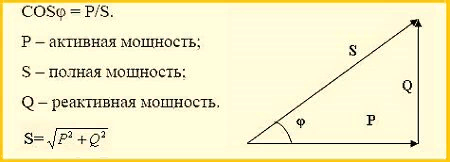

In [41]:
# создание признака с работой
df_arc['work'] = df_arc['time_heating']*df_arc['total_power']

In [42]:
# создание признака с суммарной работой
df_arc['sum_work'] = df_arc.groupby('key')['work'].transform(lambda x: x.sum())

In [43]:
# создание признака со средней общей мощностью
df_arc['sum_total_power'] = df_arc.groupby('key')['total_power'].transform(lambda x: x.mean())

In [44]:
# создание признака с количеством нагревов
df_arc['count_heating'] = df_arc.groupby('key')['time_heating'].transform(lambda x: x.count())

In [45]:
# создание признака с соотношением активной мощности к реактивной
df_arc['ratio_act_react'] = df_arc['active_power'] / df_arc['reactive_power']

In [46]:
# создание признака со средним соотношением активной мощности к реактивной
df_arc['mean_ratio_act_react'] = df_arc.groupby('key')['ratio_act_react'].transform(lambda x: x.mean())

In [47]:
# вывод на экран таблицы с нагревом электродов
df_arc

,key,start_arc_heating,end_arc_heating,active_power,reactive_power,time_heating,sum_time_heating,total_power,work,sum_work,sum_total_power,count_heating,ratio_act_react,mean_ratio_act_react
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228.0,1098.0,1.193639,272.149755,1442.377754,1.165279,5,1.420582,1.538898
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185.0,1098.0,0.959010,177.416785,1442.377754,1.165279,5,1.548395,1.538898
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172.0,1098.0,0.896038,154.118502,1442.377754,1.165279,5,1.492292,1.538898
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365.0,1098.0,1.970470,719.221394,1442.377754,1.165279,5,1.561504,1.538898
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148.0,1098.0,0.807239,119.471318,1442.377754,1.165279,5,1.671717,1.538898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14867,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439,157.0,659.0,0.640648,100.581755,460.082343,0.599903,5,1.505675,1.482661
14868,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631,180.0,659.0,0.855559,154.000682,460.082343,0.599903,5,1.292139,1.482661
14869,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654,184.0,659.0,0.874560,160.919002,460.082343,0.599903,5,1.542928,1.482661
14870,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768,57.0,659.0,0.264489,15.075853,460.082343,0.599903,5,1.514004,1.482661


Проведем декомпозицию датафреймов.

In [48]:
# декомпозиция датафрейма с нагревом электродов
df_arc = df_arc[['key', 'sum_time_heating', 'sum_total_power', 'mean_ratio_act_react', 'count_heating', 'sum_work']]
df_arc.head()

,key,sum_time_heating,sum_total_power,mean_ratio_act_react,count_heating,sum_work
0,1,1098.0,1.165279,1.538898,5,1442.377754
1,1,1098.0,1.165279,1.538898,5,1442.377754
2,1,1098.0,1.165279,1.538898,5,1442.377754
3,1,1098.0,1.165279,1.538898,5,1442.377754
4,1,1098.0,1.165279,1.538898,5,1442.377754


In [49]:
# декомпозиция датафрейма с температурой
df_temp = df_temp[['key', 'first_temperature', 'last_temperature', 'duration_heating']]
df_temp.head()

,key,first_temperature,last_temperature,duration_heating
0,1,1571.0,1613.0,861.0
1,1,1571.0,1613.0,861.0
2,1,1571.0,1613.0,861.0
3,1,1571.0,1613.0,861.0
4,1,1571.0,1613.0,861.0


Так как в одной партии несколько раз замерялась температура и производился нагрев электродов, а агрегированные признаки полностью дублируются по одному ключу, то получим уникальные строки путем удаления дубликатов в таблицах с температурой и нагревом электродов.

In [50]:
# удаление дубликатов из таблицы с нагревом электродами
df_arc = df_arc.drop_duplicates().reset_index(drop=True)
df_arc

,key,sum_time_heating,sum_total_power,mean_ratio_act_react,count_heating,sum_work
0,1,1098.0,1.165279,1.538898,5,1442.377754
1,2,811.0,0.912304,1.551834,4,881.233565
2,3,655.0,0.597907,1.583120,5,525.066777
3,4,741.0,0.953741,1.563487,4,796.911309
4,5,869.0,1.008939,1.480428,4,1199.137958
...,...,...,...,...,...,...
3208,3237,909.0,0.968996,1.384203,5,958.336236
3209,3238,546.0,0.898847,1.257794,3,555.867370
3210,3239,1216.0,0.701485,1.497918,8,1013.067719
3211,3240,839.0,0.778371,1.257343,5,729.208940


In [51]:
# удаление дубликатов из таблицы с температурой
df_temp = df_temp.drop_duplicates().reset_index(drop=True)
df_temp

,key,first_temperature,last_temperature,duration_heating
0,1,1571.0,1613.0,861.0
1,2,1581.0,1602.0,1305.0
2,3,1596.0,1599.0,1300.0
3,4,1601.0,1625.0,388.0
4,5,1576.0,1602.0,762.0
...,...,...,...,...
2468,2495,1570.0,1591.0,1137.0
2469,2496,1554.0,1591.0,1618.0
2470,2497,1571.0,1589.0,717.0
2471,2498,1591.0,1594.0,1302.0


### Шаг 3.3.  Объединение датафреймов и проверка корреляции.

In [52]:
# объединение таблиц в общий датафрейм
df_total = pd.merge(df_arc, df_temp, on='key')
df_total = pd.merge(df_total, df_gas, on='key')
df_total = pd.merge(df_total, df_bulk, on='key')
df_total = pd.merge(df_total, df_wire, on='key')

In [53]:
# вывод на экран верхней части объединенной таблицы
df_total.head()

,key,sum_time_heating,sum_total_power,mean_ratio_act_react,count_heating,sum_work,first_temperature,last_temperature,duration_heating,gas_1,...,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,1098.0,1.165279,1.538898,5,1442.377754,1571.0,1613.0,861.0,29.749986,...,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,811.0,0.912304,1.551834,4,881.233565,1581.0,1602.0,1305.0,12.555561,...,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,655.0,0.597907,1.583120,5,525.066777,1596.0,1599.0,1300.0,28.554793,...,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,741.0,0.953741,1.563487,4,796.911309,1601.0,1625.0,388.0,18.841219,...,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,869.0,1.008939,1.480428,4,1199.137958,1576.0,1602.0,762.0,5.413692,...,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
# обзор данных объединенной таблицы
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   2324 non-null   int64  
 1   sum_time_heating      2324 non-null   float64
 2   sum_total_power       2324 non-null   float64
 3   mean_ratio_act_react  2324 non-null   float64
 4   count_heating         2324 non-null   int64  
 5   sum_work              2324 non-null   float64
 6   first_temperature     2324 non-null   float64
 7   last_temperature      2324 non-null   float64
 8   duration_heating      2324 non-null   float64
 9   gas_1                 2324 non-null   float64
 10  bulk_1                2324 non-null   float64
 11  bulk_2                2324 non-null   float64
 12  bulk_3                2324 non-null   float64
 13  bulk_4                2324 non-null   float64
 14  bulk_5                2324 non-null   float64
 15  bulk_6               

In [55]:
# удалиние очень редкого признака
df_total = df_total.drop('wire_5', axis=1)

Построим тепловую карту для проверки корреляции между признаками и для исключения мультиколлинеарности, чтобы для решения задачи можно было использовать линейную регрессионную модель.

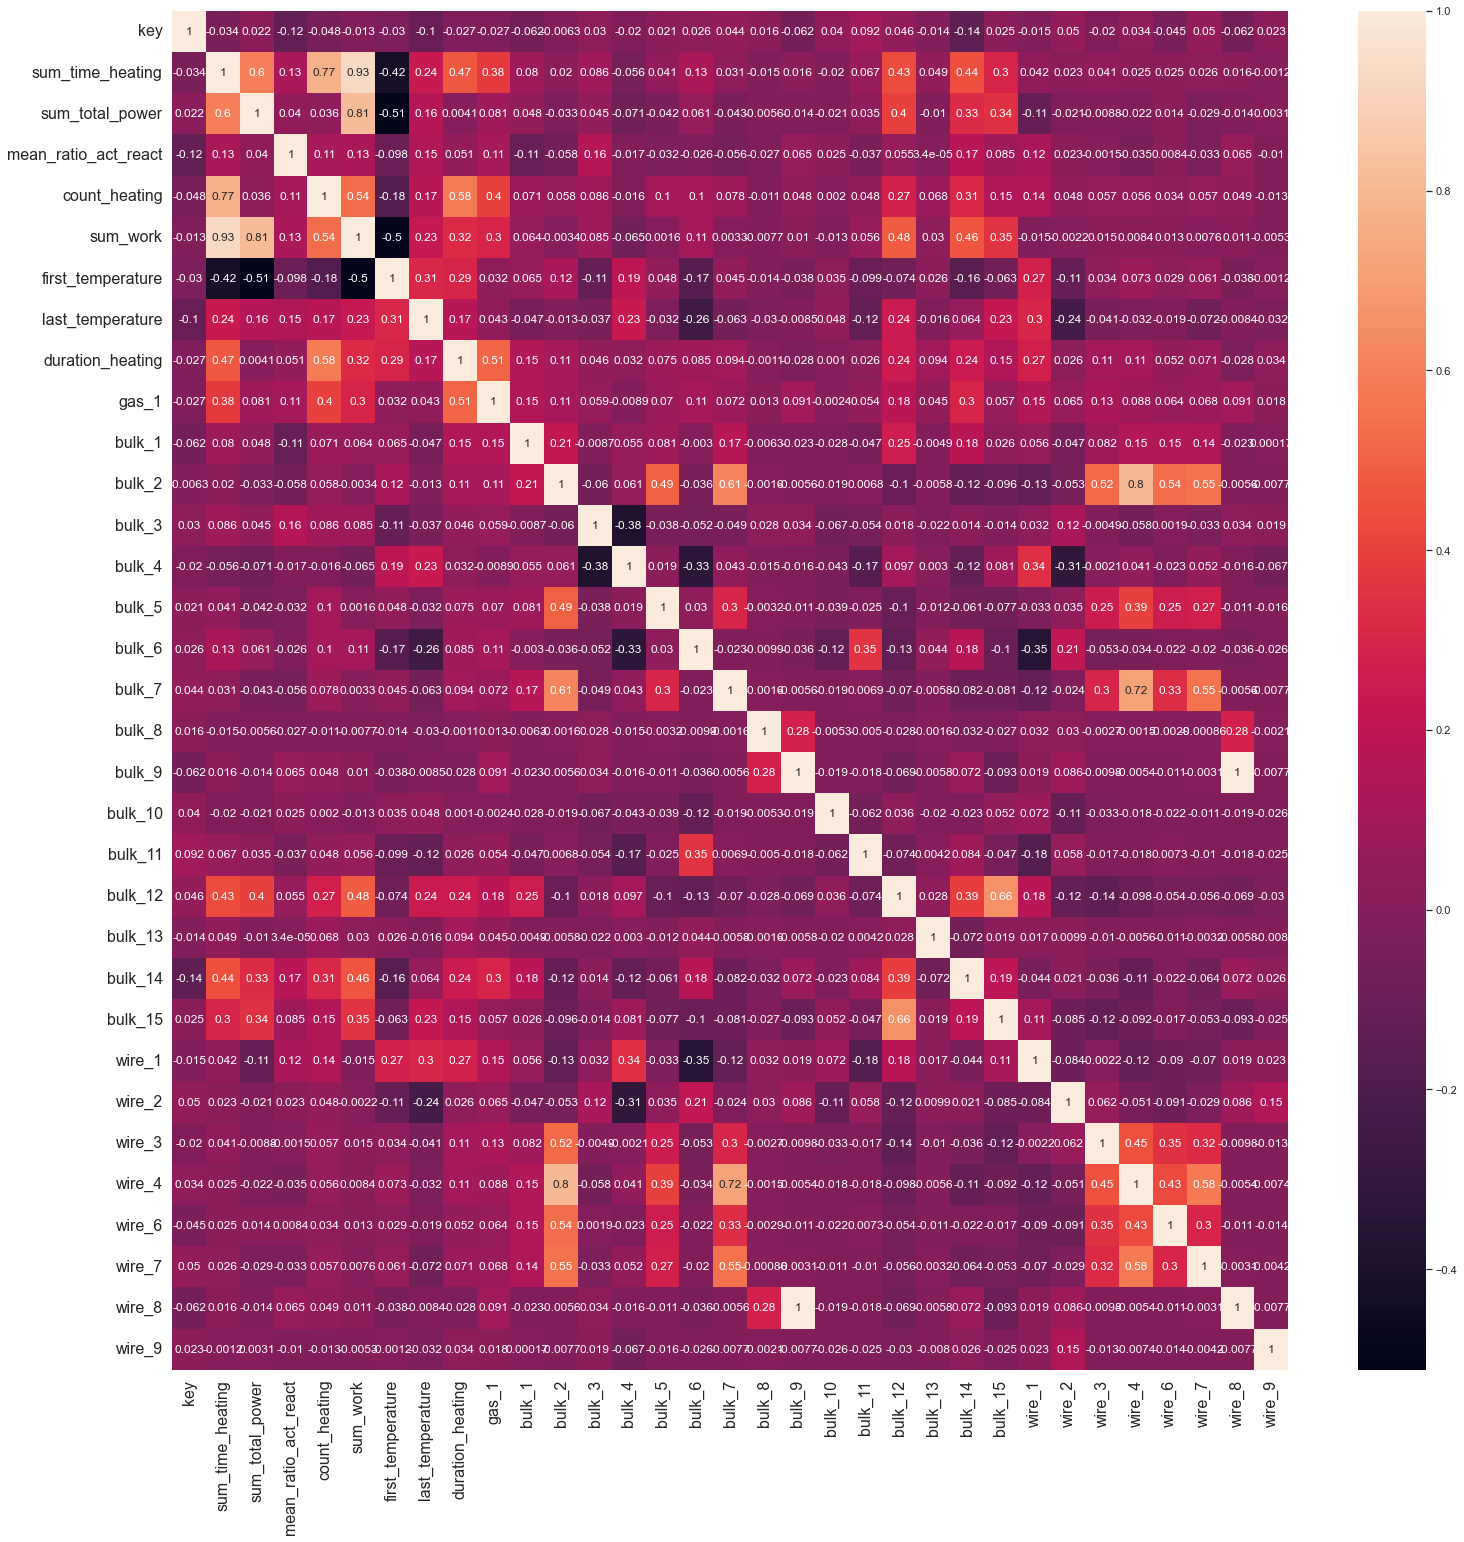

In [56]:
# построение тепловой карты для проверки корреляции между признаками
sns.set(rc = {'figure.figsize':(25,25)})
heat = sns.heatmap(df_total.corr(method='spearman'), annot=True)
heat.tick_params(labelsize=16)

- Из тепловой карты видно, что:
  - Наблюдается сильная мультиколлинеарность между признаками bulk_9 и wire_8. Удалим один из них, так как изначально это были довольно редкие признаки.
  - Также существует сильная связь между новыми признаками: суммарной работой и суммарным временем нагрева и количеством нагревов. Также удалим один из признаков.
- Наибольшая корреляция с целевым признаком:
  - Довольно слабая в районе 0.3 у признаков wire_1, bulk_4, bulk_6(обратная), bulk_12 и bulk_15. 
  -  Также слабая корреляция есть у суммарной работы, суммарного времени нагрева и начальной температуры.

In [57]:
# удаление признаков с мультиколлинеарностью
df_total = df_total.drop(['key', 'bulk_9', 'sum_work'], axis=1)

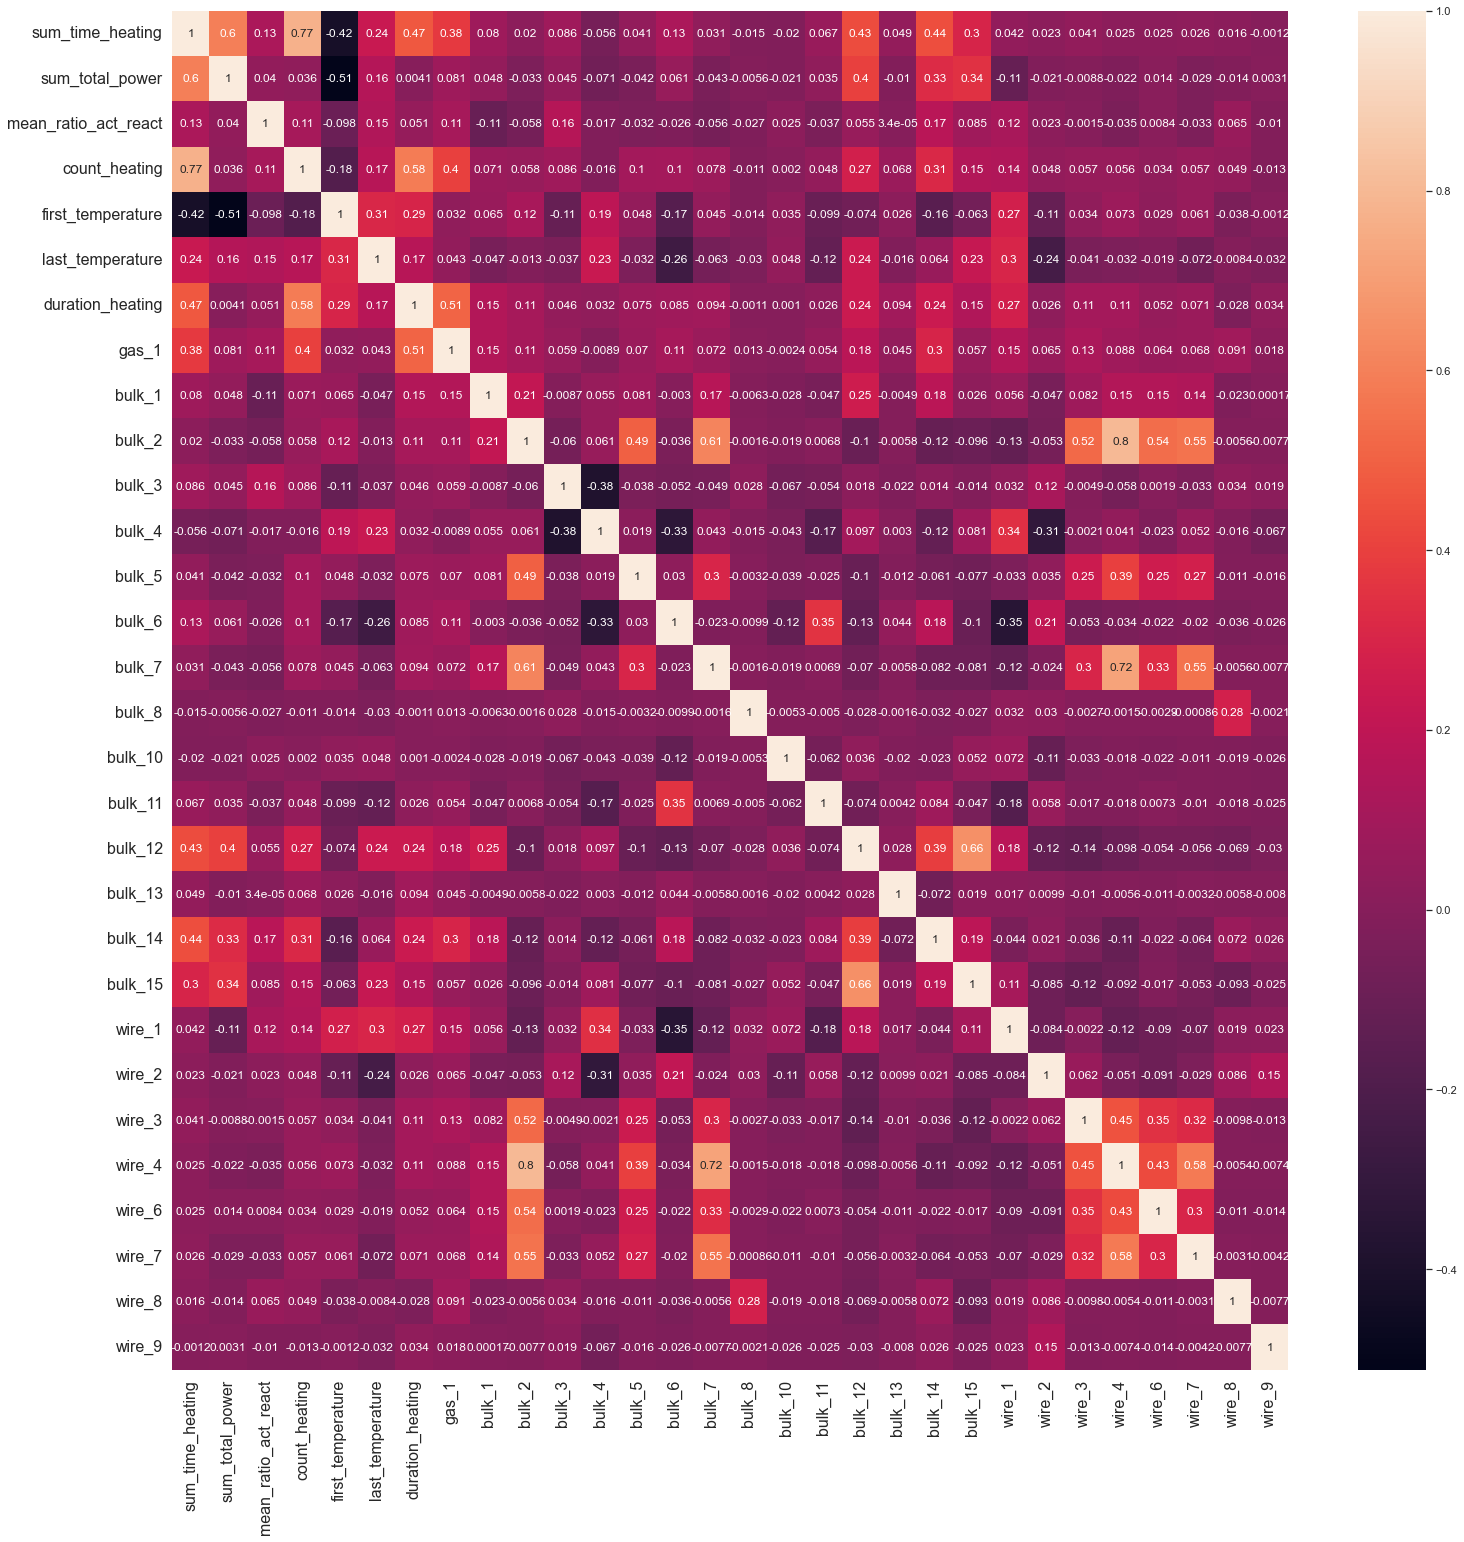

In [58]:
sns.set(rc = {'figure.figsize':(25,25)})
heat = sns.heatmap(df_total.corr(method='spearman'), annot=True)
heat.tick_params(labelsize=16)

## Шаг 4. Подготовка моделей для обучения.

### Шаг 4.1. Разделение данных на выборки и подготовка моделей для обучения.

Для решения нашей задачи привлечем из разных типов 5 алгоритмов машинного обучения(МО):
- Dummy-модель "DummyRegressor"
- Линейная модель "LinearRegression"
- Модель дерева-решений "DecisionTreeRegressor"
- Две модели градиентного бустинга:
  - "CatBoostRegressor"
  - "LGBMRegressor"

In [59]:
# создание набора с признаками и целевым признаком
X, y = df_total.drop('last_temperature', axis=1), df_total['last_temperature']

In [60]:
# разделение общих выборок на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=190922)

In [61]:
# проверка размера выборок
print( f'Размер тренировочной выборки: {X_train.shape}, {y_train.shape}.')
print(f'Размер тестовой выборки: {X_test.shape}, {y_test.shape}.')

Размер тренировочной выборки: (1743, 29), (1743,).
Размер тестовой выборки: (581, 29), (581,).


In [62]:
1743+581

2324

In [63]:
# создание "pipeline" для пяти моделей МО
pipe_dumr = Pipeline([('scaler', StandardScaler()),
                    ('reg', DummyRegressor())])

pipe_lr = Pipeline([('scaler', StandardScaler()),
                    ('reg', LinearRegression())])

pipe_dr = Pipeline([('scaler', StandardScaler()),
                    ('reg', DecisionTreeRegressor(random_state=190922))])

pipe_cb = Pipeline([('scaler', StandardScaler()),
                    ('reg', CatBoostRegressor(random_state=190922))])

pipe_lgbm = Pipeline([('scaler', StandardScaler()),
                    ('reg', LGBMRegressor(random_state=190922))])

In [64]:
# создание списков-словарей с параметрами моделей МО

param_dumr = {'reg__strategy': ['median']}

param_lr = {
            }

param_dr = {'reg__max_depth': [4, 8, 14],
             'reg__splitter': ['best', 'random'],
             'reg__max_features': ['sqrt']}

param_cb = {'reg__silent' : [True],
             'reg__loss_function': ['MAE'],
             'reg__depth': [6, 12],
             'reg__learning_rate' : [0.01, 0.05, 0.1],
             'reg__iterations' : [100, 200]}

param_lgbm = {'reg__max_depth': [6, 14],
             'reg__learning_rate' : [0.01, 0.05, 0.3, 0.7],
             'reg__n_estimators' : [100, 200]}

In [65]:
# создание переменных с записью в них GridSearchCV (далее GSCV) для поиска оптимальных параметров по каждой модели МО

DUMR = GridSearchCV(estimator=pipe_dumr,
            param_grid=param_dumr,
            scoring='neg_mean_absolute_error',
                 cv=3) 

LR = GridSearchCV(estimator=pipe_lr,
            param_grid=param_lr,
            scoring='neg_mean_absolute_error',
                 cv=3) 

DR = GridSearchCV(estimator=pipe_dr,
            param_grid=param_dr,
            scoring='neg_mean_absolute_error',
                 cv=3)

CB = GridSearchCV(estimator=pipe_cb,
            param_grid=param_cb,
            scoring='neg_mean_absolute_error',
                 cv=3)

LGBM = GridSearchCV(estimator=pipe_lgbm,
            param_grid=param_lgbm,
            scoring='neg_mean_absolute_error',
                   cv=3)

In [66]:
# создание списка с GridSearchCV(GSCV) по каждой модели МО
grids = [DUMR, LR, DR, CB, LGBM]

# создание словаря с наименованием каждой модели МО
grid_dict = {0: 'DummyRegressor',
             1: 'LinearRegression', 
             2: 'DecisionTreeRegressor',
             3: 'CatBoostRegressor',
             4: 'LGBMRegressor'}

### Шаг 4.2. Обучение моделей и выбор лучшей.

Создадим функцию:
- Принимает аргументами: тренировочную или тестовую выборки(отдельно с признаками и целевым признаком). А также именованные аргументы: с начальным завышенным значением MAE(с которым в дальнейшем в цикле сравнивается значение MAE для разных моделей), нулевое значение лучшей модели и ее индекса, наименование выборки на которой производится предсказание(тренировочная или тестовая). 
- Внутри функции:
  - Выводятся на экран параметры модели, при которых достигается лучшее MAE, лучшее значение MAE.
  - Вычисляется время работы по обучению и предсказанию модели.
  - Далее параметры модели, время работы и лучший MAE добавляются в словарь.
  - Вывод на экран модели с лучшим MAE.
- Функция возвращает словарь с параметрами, временем обучения и предсказания, а также MAE для всех моделей.

In [67]:
# создание функции для выбора модели с лучшим MAE
def choose_model(list_grids, feature, target, best_score, best_reg, best_gs, name_sample):
    best_model_params = {'Модель' : [],
                        'Лучшие параметры модели' : [],
                        'Лучшее MAE модели' : [],
                        'Время обучения модели' : [],
                        'Время предсказания модели' : []}
    for idx, gs in enumerate(list_grids):
        print('Модель:{}'.format(grid_dict[idx]))
        print()
        t0 = time()
        gs.fit(feature, target)
        time_fit = time()-t0
        t1 = time()
        gs.predict(feature)
        time_predict = time() - t1
        print('Лучшие параметры модели:', gs.best_params_)
        print()
        print('MAE для модели {} на {} выборке: {:.2f}'.format(grid_dict[idx], name_sample, abs(gs.best_score_)))
        print() 
        if abs(gs.best_score_) < best_score:
            best_score = abs(gs.best_score_)
            best_gs = gs
            best_reg = idx
        best_model_params['Модель'].append(grid_dict[idx])
        best_model_params['Лучшие параметры модели'].append(gs.best_params_)
        best_model_params['Лучшее MAE модели'].append(abs(gs.best_score_))
        best_model_params['Время обучения модели'].append(time_fit)
        best_model_params['Время предсказания модели'].append(time_predict)
        print('\n')
    print('\n')
    print('Лучшая модель на {} выборке: {}'.format(name_sample, grid_dict[best_reg]))
    print()
    print('Лучший показатель MAE на {} выборке: {:.2f}'.format(name_sample, best_score))
    print('\n\n')
    return best_model_params

In [68]:
# вызов функции для подбора модели с лучшим MAE на тренировочной выборке и запись результата в словарь
dict_train_model = choose_model(grids, X_train, y_train, best_score=1000, best_reg=0, best_gs='', name_sample='тренировочной')

Модель:DummyRegressor

Лучшие параметры модели: {'reg__strategy': 'median'}

MAE для модели DummyRegressor на тренировочной выборке: 7.88



Модель:LinearRegression

Лучшие параметры модели: {}

MAE для модели LinearRegression на тренировочной выборке: 5.86



Модель:DecisionTreeRegressor

Лучшие параметры модели: {'reg__max_depth': 4, 'reg__max_features': 'sqrt', 'reg__splitter': 'best'}

MAE для модели DecisionTreeRegressor на тренировочной выборке: 7.53



Модель:CatBoostRegressor

Лучшие параметры модели: {'reg__depth': 6, 'reg__iterations': 200, 'reg__learning_rate': 0.1, 'reg__loss_function': 'MAE', 'reg__silent': True}

MAE для модели CatBoostRegressor на тренировочной выборке: 5.74



Модель:LGBMRegressor

Лучшие параметры модели: {'reg__learning_rate': 0.05, 'reg__max_depth': 14, 'reg__n_estimators': 200}

MAE для модели LGBMRegressor на тренировочной выборке: 5.69





Лучшая модель на тренировочной выборке: LGBMRegressor

Лучший показатель MAE на тренировочной выборке: 5.69


In [69]:
# создание датафрейма из словаря с параметрами и результатами работы моделей на тренировочной выборке
pd.set_option('max_colwidth', 150)
df_train_param = pd.DataFrame(data=dict_train_model)
df_train_param

,Модель,Лучшие параметры модели,Лучшее MAE модели,Время обучения модели,Время предсказания модели
0,DummyRegressor,{'reg__strategy': 'median'},7.879518,0.032938,0.002000
1,LinearRegression,{},5.856107,0.032916,0.002000
2,DecisionTreeRegressor,"{'reg__max_depth': 4, 'reg__max_features': 'sqrt', 'reg__splitter': 'best'}",7.526900,0.196208,0.002006
3,CatBoostRegressor,"{'reg__depth': 6, 'reg__iterations': 200, 'reg__learning_rate': 0.1, 'reg__loss_function': 'MAE', 'reg__silent': True}",5.741755,410.191401,0.005002
4,LGBMRegressor,"{'reg__learning_rate': 0.05, 'reg__max_depth': 14, 'reg__n_estimators': 200}",5.685794,5.343649,0.011622


- Все основные 4 модели показали MAE лучше, чем Dummy-модель.
- Модель дерево-решений "DecisionTreeRegressor" показала наихудшее MAE, время обучения лучшее.
- Лучший MAE у "LGBMRegressor", а время обучения существенно лучше, чем у показавшей почти такой же результат "CatBoostRegressor").
- MAE Линейной модели "LinearRegression" не сильно уступает метрике лучшей модели, а время обучения значительно быстрее.

### Шаг 4.3. Тестирование лучшей модели.

In [70]:
# проверка лучшей модели "LGBMRegressor" на тестовой выборке и вывод на экран МАЕ
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

LGBM_reg = LGBMRegressor(learning_rate=0.05, max_depth=14, n_estimators=200, random_state=190922)
LGBM_reg.fit(X_train_scaled, y_train)
predictions = LGBM_reg.predict(X_test_scaled)
MAE = mean_absolute_error(y_test, predictions)

print('Среднее абсолютное отклонение на тестовой выборке:', MAE)

Среднее абсолютное отклонение на тестовой выборке: 5.641848240415231


In [71]:
# создание датафрейма из словаря с параметрами и результатами работы модели LGBMRegressor на тестовой выборке
df_test_param = pd.DataFrame(data={'наименование модели':['LGBMRegressor'],
                                  'гиперпараметры': ['learning_rate:0.05,  max_depth:14,  n_estimators:200'],
                                  'итоговый MAE': ['5.64']})
df_test_param

,наименование модели,гиперпараметры,итоговый MAE
0,LGBMRegressor,"learning_rate:0.05, max_depth:14, n_estimators:200",5.64


### Шаг 4.4. Определение влияния признаков на целевой признак.

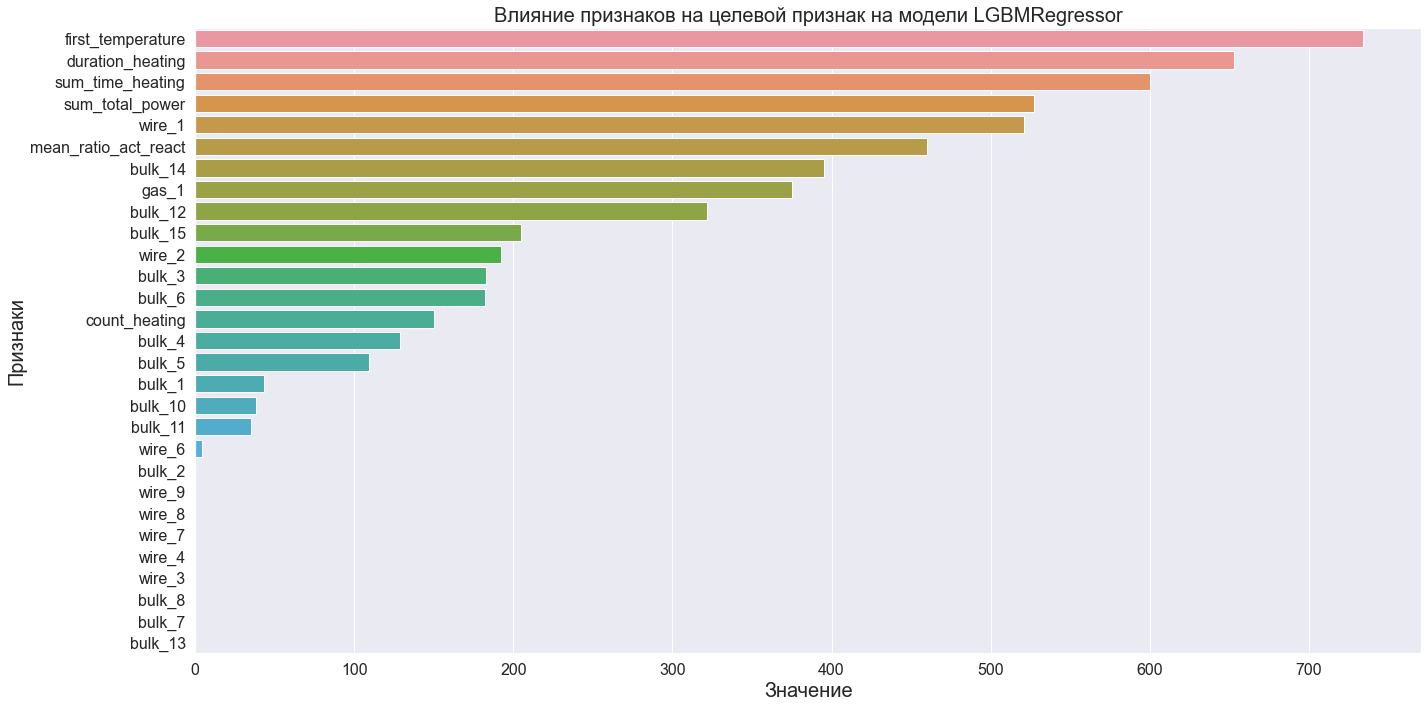

In [72]:
# построение столбчатой диаграммы влияния признаков на целевой признак
feature_imp = pd.DataFrame(sorted(zip(LGBM_reg.feature_importances_, X.columns)), columns=['Значение','Признаки'])

plt.figure(figsize=(20, 10))
bar = sns.barplot(x="Значение", y="Признаки", data=feature_imp.sort_values(by="Значение", ascending=False))
bar.tick_params(labelsize=16)
bar.set_xlabel('Значение', fontsize=20)
bar.set_ylabel('Признаки', fontsize=20)
plt.title('Влияние признаков на целевой признак на модели LGBMRegressor', fontsize=20)
plt.tight_layout()
plt.show()

- Наибольшее влияние на целевой признак оказывают влияние:
   - первоначальная температура
   - суммарное время нагрева
   - продолжительность нагрева
   - общая мощность
- Пренебречь для обучения модели можно следующими признаками:
   - сыпучие материалы под номерами 2, 7, 8, 13
   - проволочные материалы под номерами 3, 4, 6, 7, 8, 9.
   
Но необходимо помнить, что все признаки с малым влиянием скорее всего просто редко используются в технологическом процессе, и иногда могут добавляться, что модель на будущее также должна учитывать.

## Шаг 5. Вывод.

- Все 4 модели показали лучший результат, чем Dummy-модель. 
- Линейная модель LinearRegression показала на тренировочной выборке хороший результат и быстрое время обучения.
- Лучшая метрика MAE при кросс-валидации показана моделью LGBMRegressor. 
- На тестовой выборке результат получился даже немного лучше, чем на обучающей.
- Наибольшее влияние на целевой признак в лучшей модели оказывают факторы начальной температуры, суммарного времени нагрева и мощности.
- Факторы, которые пока можно не учитывать(до изменения технологии): 
  - сыпучие материалы под номерами 2, 5, 7, 8, 13.
  - проволочные материалы под номерами 3, 4, 7, 8, 9.
- Данные по гиперпараметрам с лучшей метрикой загружены в таблицу:

In [73]:
df_test_param

,наименование модели,гиперпараметры,итоговый MAE
0,LGBMRegressor,"learning_rate:0.05, max_depth:14, n_estimators:200",5.64


# Отчет по проведенной работе.

- Все пункты плана были выполнены. Последние 4 пункта(формирование признаков, разбиение на выборки, обучение моделей и тестирование лучшей) были объединены в один раздел и разбиты по подпунктам.
- В плане не прописаны, но выполнены следующие шаги:
  - Построена столбчатая диаграмма влияния факторов на целевой признак.
- В проекте наибольшие трудности были вызваны при формировании и расчете дополнительных признаков.
- Можно выделить следующие ключевы шаги проекта:
  - Создание новых признаков(первая температура, суммарное время нагрева, суммарная мощность, длительность между первым и последним замером), которые в итоге оказали наибольшее влияние на целевой признак.
  - Удаление некорректных ключей с пропусками и аномалиями в целевом признаке.
  - Проверка корреляции признаков и мультиколлинеарности.
  - Выбор моделей и подбор гиперпараметров для их обучения.
- Итоговая модель:
  - Модель градиентного бустинга "LGBMRegressor", которая показала лучший результат метрики МАЕ на обучающей выборке, а также довольно хороший результат на тестовой выборке.
  - Время обучения и предсказания итоговой модели также одни из лучших и немногим уступают модели линейной регрессии "LinearRegression".
- Для получения итоговой модели мы создали несколько новых признаков, а также выделили целевой признак путем аггрегирования данных по ключу(номеру партии стали):
  - first_temperature - первый замер температуры.
  - duration_heating - длительность времени между первым замером и последним
  - sum_time_heating - общее время нагрева
  - sum_total_power - общая мощность
  - mean_ratio_act_react - среднее отношение активной мощности к реактивной
  - count_heating - количество нагревов
  - sum_work - общая работа
  Все эти признаки достаточно сильно влияют в модели на целевой признак. Cуммарную работу удалили вследствие мультиколлинеарности к суммарному времени нагрева. Также удалили bulk_9  из-за сильной корреляции к wire_8, wire_5 удален вследствие удаления ключей, имеющих пропуски в целевом признаке.
- Признаки группы bulk(сыпучих материалов) и wire(проволочных материалов), кроме удаленных, также использовались в итоговой модели, но влияние их меньше и обусловлено частотой их использования в технологическом процессе. Пропуски в данных с этими признаками заполнили нулями.
- Пропуски в целевом признаке удалили вместе с ключами, а также удалили ключи с температурой ниже 1500 градусов и отрицательной реактивной мощностью.
- Данные по тестированию модели записаны в таблице:

In [74]:
df_test_param

,наименование модели,гиперпараметры,итоговый MAE
0,LGBMRegressor,"learning_rate:0.05, max_depth:14, n_estimators:200",5.64
